# Cost-Aware A/B Testing

### Background

A/B testing (a.k.a. randomized controlled trials, randomized experiments) is one of the most important ways to understand causal relationships. In a typical A/B testing setup, there will be one (or more) treatment group and one control group, and a pool of subjects are randomly assigned to the experimental groups based on pre-determined proportions (e.g., equal assignments). 

While this is a perfectly legitimate way to test causality, it can be inefficient in practice. Imagine a clinical trial of two treatment options: drug A and placebo B, and let's assume that (in fact) drug A is much more effective than placebo B in treating a certain condition. Then, every subject that is assigned to the placebo group has to (unfortunately) endure some non-trivial costs, i.e., their conditions are not treated timely even when an effective drug exists. Note that some of the costs are necessary - after all, we don't know the effectiveness of drug A a priori and need a sufficient number of people in both groups to find out. However, as the effectiveness of drug A becomes clearer and clearer over the course of the experiment, perhaps it makes sense to gradually reduce the assignment to the placebo group, in order to reduce costs. 

This is the basic idea behind **cost-aware A/B testing**. It is an important emerging topic in experimentation, and has attracted a lot of attention from both researchers and practitioners.

### Problem formulation

For this A/B testing task, the goal is first to perform an experiment to estimates the treatment effects of each treatment option with a certain statistical significance. Second we also want to minimize regret (cost), which is the same as maximizing the total and average treatment effect. This means that when we are certain that some treatment is more robust than the others, we want to assign more subjects to that treatment group to reduce the cost of assigning too many subjects to the ineffective treatment options. To do so, I will use multi-armed bandit model with different value calculation methods to dynamically adjust the subject assignment as the experiment progresses.

For the multi-armed bandit model, the setting is as follows:
 - agent: the decision maker who assigns each subject to each treatment group
 - environment: all the treatment options available with a certain distribution
 - actions: assign a subject to a specific treatment group
 - rewards: large reward if the agent assign a subject to an effective treatment option, small reward otherwise
 - state: the distribution of the treatment effect of each group, which is static over time
 - value: how likely is each action in achieving higher reward
 - policy: a strategy of what action to take at each time step
 - agent's objective: maximize the rewards (treatment effect)

The methods I will try in this notebook are

1. Random assignment
2. Greedy with optimistic initialization
3. Epsilon-Greedy
4. Upper Confidence Bound
5. Greedy with standard error

For the last appraoch 'Greedy with standard error', I will inconporate the standard error directly in the value estimation calculation to make sure that we can reduce the uncertainty of our treatment effect estimates over time.

To evaluate the performance of each appraoch, I will use the following 3 plots:

- Total Treatment Effect
- Average Treatment Effect
- Combined Standard Error

The total and average treatment effect plots are used to reflect how well we maximize the treatment effect over time. The combined standard error plot is used to display how well our estimates of the mean of treatment effects are. This also reflects the uncertainty in our estimates as well. 

In [40]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

### Experiment Simulation Setup

Let's specify some numbers required for the experiment. I will assume that there are 8 treatments and 1000 subjects in this experiment. The true treatment effects of each treatment is drawn from a normal distribution ~ N(0.5, 1). The variances of the treatment effects are drawn from a uniform distribution ~ Unif(0.5, 1).

In [41]:
k = 8  # Number of tretment options
N = 1000  # Number of subjects

np.random.seed(12345)
# True treatment effects are drawn from normal distribution ~ N(0.5, 1)
true_te = np.random.normal(loc=0.5, size = k)
# Variances for each treatment effect are drawn from uniform distribution ~ U(0.5,1)
te_vars = np.random.uniform(low=0.5, high=1, size=k)  
print(true_te)
print(te_vars)

print(f'Best treatment is treatment {np.argmax(true_te)} with the treatment effect of {np.max(true_te)}')

[ 0.29529234  0.97894334 -0.01943872 -0.0557303   2.46578057  1.89340583
  0.59290788  0.78174615]
[0.87445332 0.82678494 0.8738574  0.98065337 0.50419415 0.55322219
 0.64935186 0.82820559]
Best treatment is treatment 4 with the treatment effect of 2.465780572502714


In [42]:
def treat(treatment_idx):
    """Function to assign treatment effect to a subject based on a treatment index assigned"""
    return np.random.normal(loc = true_te[treatment_idx], scale = te_vars[treatment_idx])

treat(2)

0.2208647600307722

Let's define some helper functions

In [43]:
def combine_se(standard_error: list, record: dict):
    """Function to calculate combined standard error of all treatments"""
    temp = 0
    for i in record:
        if record[i]: # Only if there is at least 1 sample of that treatment
            temp += (standard_error[i] ** 2) / len(record[i])

    return temp ** 0.5


In [44]:
def update(average, standard_error, record, counter, treatment_idx, treatment_effect):
    """Function to update the average and standard error of the treatment effect of each treatment"""
    # update average
    average[treatment_idx] = (average[treatment_idx]*counter[treatment_idx] + \
                              treatment_effect) / (counter[treatment_idx] + 1)
    # update record
    record[treatment_idx].extend([treatment_effect])
    # update standard error of treatment_idx
    if len(record[treatment_idx]) > 1:
        standard_error[treatment_idx] = sem(record[treatment_idx])
    else: # if there is only 1 record, set to an arbitraty large number
        standard_error[treatment_idx] = 0.5
    # Update counter
    counter[treatment_idx] += 1
    
    return average, standard_error, record, counter

### 1. Random assignment
Let's first try assigning subjects to treatments randomly

Number of subjects in each treatment group: [226, 242, 258, 282, 230, 242, 254, 266]
Final combined_se of the random approach: 0.017286727441733842


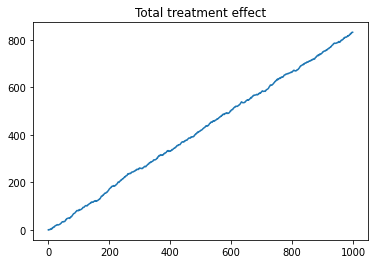

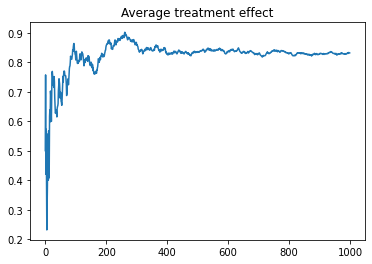

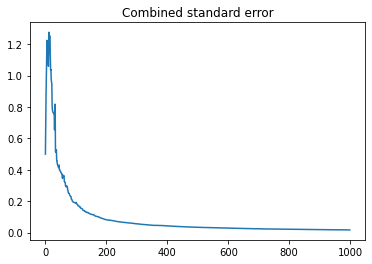

In [45]:
te_random = []
avg_te = [0]*k 
sumte_random = []
avgte_random = []
counter = [0]*k

# For recording standard errors
se_random = [0] * k
combined_se_random = [] 
record_random = {i:[] for i in range(k)}

np.random.seed(12345)
for t in range(N):
    # randomly assign a subject to a treatment group
    treatment_idx = np.random.randint(low = 0, high = k)
    counter[treatment_idx] += 1
    treatment_effect = treat(treatment_idx)
    te_random.append(treatment_effect)
    # record sum and average reward up to this round
    sumte_random.append(np.sum(te_random))
    avgte_random.append(np.mean(te_random))
    # update
    avg_te, se_random, record_random, counter = update(avg_te, se_random, record_random, 
                                                       counter, treatment_idx, treatment_effect)
    # record combined_se
    combined_se_random.append(combine_se(se_random, record_random))

print('Number of subjects in each treatment group:', counter)
print('Final combined_se of the random approach:', combined_se_random[-1])

plt.plot(sumte_random)
plt.title("Total treatment effect")
plt.show()

plt.plot(avgte_random)
plt.title("Average treatment effect")
plt.show()

plt.plot(combined_se_random)
plt.title("Combined standard error")
plt.show()

The plot shows a positive total and average treatment effect which is ok but we have to compare with other methods to compare this. The combined standard error trend shows that as we have more subjects we are more certain about our estimates of the effect of each treatment option, which is good.
However, it's obvious that this is not a good strategy since we are assigning almost the same proportion of subjects to each group. In other words, we should have assigned more subjects to the group that seems to be more effective, as we are trying to reduce the cost of assigning the subjects to ineffective treatments.

### 2. Greedy with optimistic initialization

One way to reduce the cost is to always choose the treatment with the highest treatment effect based on historical data. We will try using greedy appraoch with optimistic intitialization to do this.

Number of subjects in each treatment group: [1, 1, 1, 1, 990, 4, 1, 1]
Final combined_se of the greedy opt approach: 1.2322298995697318


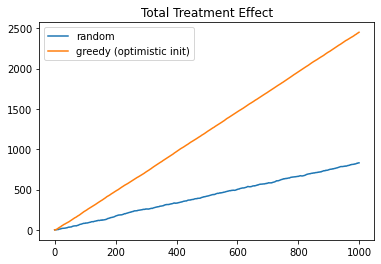

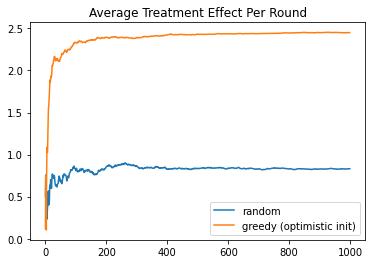

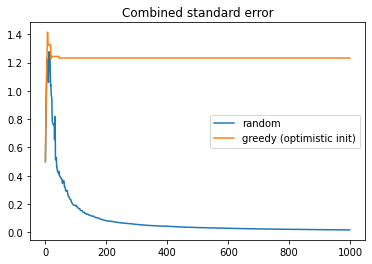

In [46]:
# Greedy strategy with optimistic initialization
avg_te = [5]*k  # optimistic initial values
counter = [0]*k  # initialize counter
te_greedy_optint = []
sumte_greedy_optint = []
avgte_greedy_optint = []

# For recording standard errors
se_greedy_opt = [0] * k
combined_se_greedy_opt = [] 
record_greedy_opt = {i:[] for i in range(k)}

np.random.seed(12345)
for t in range(N):
    # Choose best treatment from past average te
    treatment_idx = np.argmax(avg_te)
    treatment_effect = treat(treatment_idx)
    te_greedy_optint.append(treatment_effect)
    # record sum and average treatment effect up to this round
    sumte_greedy_optint.append(np.sum(te_greedy_optint))
    avgte_greedy_optint.append(np.mean(te_greedy_optint))
    # update
    avg_te, se_greedy_opt, record_greedy_opt, counter = update(avg_te, se_greedy_opt, record_greedy_opt, 
                                                               counter, treatment_idx, treatment_effect)
    # record combined_se
    combined_se_greedy_opt.append(combine_se(se_greedy_opt, record_greedy_opt))


print('Number of subjects in each treatment group:', counter)
print('Final combined_se of the greedy opt approach:', combined_se_greedy_opt[-1])

# plot
plt.plot(sumte_random)
plt.plot(sumte_greedy_optint)
plt.title("Total Treatment Effect")
plt.legend(["random", "greedy (optimistic init)"])
plt.show()

plt.plot(avgte_random)
plt.plot(avgte_greedy_optint)
plt.title("Average Treatment Effect Per Round")
plt.legend(["random", "greedy (optimistic init)"])
plt.show()

plt.plot(combined_se_random)
plt.plot(combined_se_greedy_opt)
plt.title("Combined standard error")
plt.legend(["random", "greedy (optimistic init)"])
plt.show()

Here we notice that the greedy approach with optimistic initilization gives a much better (higher) total and average treatment effect compared to the random approach. However, one big tradeoff of this appraoch is the lack of exploration, since we assigned almost all the subjects to treatment 4 and to each of the other groups only once. 

This is problematic since first we don't know if treatment 4 is actually the best treatment or it's just by chance. Second, apart from the cost, we also care about the true treatment effect of each group meaning that we want to get a good approximation of the treatment effects as well, which we failed to do so here, as we can see from a combined standard error that did not reduce over time. 

### 3. Epsilon Greedy Approach

Number of subjects in each treatment group: [24, 22, 13, 23, 852, 21, 25, 20]
Final combined_se of the epsilon greedy approach: 0.09596333469711156


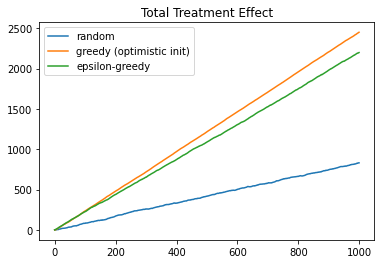

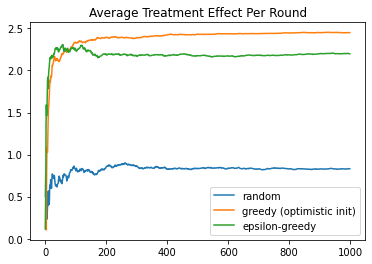

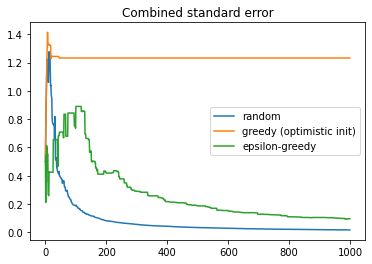

In [47]:
# Epsilon Greedy strategy 
avg_te = [0]*k  
counter = [0]*k 
te_eps_greedy = []
sumte_eps_greedy = []
avgte_eps_greedy = []
eps = 0.15

# For recording standard errors
se_eps_greedy = [0] * k
combined_se_eps_greedy = [] 
record_eps_greedy = {i:[] for i in range(k)}

np.random.seed(12345)
for t in range(N):
    # Choose best treatment from past average te
    treatment_idx = np.argmax(avg_te)
    treatment_effect = treat(treatment_idx)

    # Check if we choose explore other treatment groups instead
    explore = np.random.binomial(1, eps)
    if explore:
        # randomly assign other treatments
        treatment_idx = np.random.choice(np.setdiff1d(range(k), treatment_idx))
        treatment_effect = treat(treatment_idx)
    
    te_eps_greedy.append(treatment_effect)
    # record sum and average treatment effect up to this round
    sumte_eps_greedy.append(np.sum(te_eps_greedy))
    avgte_eps_greedy.append(np.mean(te_eps_greedy))
    # update
    avg_te, se_eps_greedy, record_eps_greedy, counter = update(avg_te, se_eps_greedy, record_eps_greedy,
                                                               counter, treatment_idx, treatment_effect)
    # record combined_se
    combined_se_eps_greedy.append(combine_se(se_eps_greedy, record_eps_greedy))

print('Number of subjects in each treatment group:', counter)
print('Final combined_se of the epsilon greedy approach:', combined_se_eps_greedy[-1])

# plot
plt.plot(sumte_random)
plt.plot(sumte_greedy_optint)
plt.plot(sumte_eps_greedy)
plt.title("Total Treatment Effect")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy"])
plt.show()

plt.plot(avgte_random)
plt.plot(avgte_greedy_optint)
plt.plot(avgte_eps_greedy)
plt.title("Average Treatment Effect Per Round")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy"])
plt.show()

plt.plot(combined_se_random)
plt.plot(combined_se_greedy_opt)
plt.plot(combined_se_eps_greedy)
plt.title("Combined standard error")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy"])
plt.show()

Here we see that the total and average treatment effect are not as good as the greedy with optimistic initialization approach, but the values we get are still high. The most important thing is now we explore more of the other treatment options apart from treatment 4. This results in the decreasing trend of the combined standard error as we have more subjects, although it needs some number of subjects to converge. This indicates that we are more certain about our estimate of the treatment effects over time. 

Drawbacks from this approach are first that it needs some number of subjects for the combined standard error to converge. Second, even when we are certain about the estimates of the trement effects, we still assign subjects to random groups with probability of epsilon.

### 4. Upper-Confidence-Bound Method

To solve the problem as mentioned in the epsilon greedy method, here we will use UCB method to dynamically adjust the amount of exploration by trying the actions that are under explored.

In [48]:
# let's define a function to calculate the adjusted values under UCB
def ucb_calc(curr_values, t, counter, c):
    ucb_values = [0]*len(curr_values)
    for i in range(k):
        if counter[i] == 0:
            ucb_values[i] = curr_values[i] + 9999.99   # some very large number to represent "infinity"
        else:
            ucb_values[i] = curr_values[i] + c * np.sqrt(np.log(t) / counter[i])
    return ucb_values

Number of subjects in each treatment group: [12, 16, 11, 10, 824, 95, 15, 17]
Final combined_se of UCB approach: 0.1736470317934289


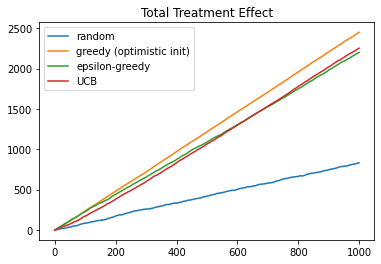

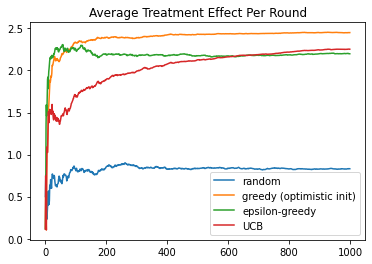

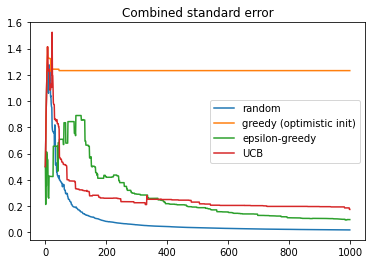

In [49]:
# UCB
avg_te = [0]*k 
counter = [0]*k
te_ucb = []
sumte_ucb = []
avgte_ucb = []
c = 3

# For recording standard errors
se_ucb = [0] * k
combined_se_ucb = [] 
record_ucb = {i:[] for i in range(k)}

np.random.seed(12345)
for t in range(N):
    # Calculate ucb values
    ucb_values = ucb_calc(avg_te, t+1, counter, c)

    # Choose best treatment from ucb values
    treatment_idx = np.argmax(ucb_values)
    treatment_effect = treat(treatment_idx)
    te_ucb.append(treatment_effect)
    # record sum and average treatment effect up to this round
    sumte_ucb.append(np.sum(te_ucb))
    avgte_ucb.append(np.mean(te_ucb))
    # update
    avg_te, se_ucb, record_ucb, counter = update(avg_te, se_ucb, record_ucb, 
                                                 counter, treatment_idx, treatment_effect)
    # record combined_se
    combined_se_ucb.append(combine_se(se_ucb, record_ucb))

print('Number of subjects in each treatment group:', counter)
print('Final combined_se of UCB approach:', combined_se_ucb[-1])

# plot
plt.plot(sumte_random)
plt.plot(sumte_greedy_optint)
plt.plot(sumte_eps_greedy)
plt.plot(sumte_ucb)
plt.title("Total Treatment Effect")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy", 'UCB'])
plt.show()

plt.plot(avgte_random)
plt.plot(avgte_greedy_optint)
plt.plot(avgte_eps_greedy)
plt.plot(avgte_ucb)
plt.title("Average Treatment Effect Per Round")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy", 'UCB'])
plt.show()

plt.plot(combined_se_random)
plt.plot(combined_se_greedy_opt)
plt.plot(combined_se_eps_greedy)
plt.plot(combined_se_ucb)
plt.title("Combined standard error")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy", 'UCB'])
plt.show()

Here we see that the UCB appraoch performed really good in almost all aspects. The method explored more at the beginning resulting more number of subjects needed for the average treatment effect to reach a certain value. It's clear that the combined standard error here decreased much faster than the epsilon-greedy. However, after a while the combined standard error did not change much as a result of less exploration.

### 5. Greedy with Standard Error

Since we also care about how good our estimates of the true mean of the treatment effects are, I will try to directly incorporate the standard error term in the value calculation. This way we will iteratively reduce the uncertainty in the estimates of the treatment effects by exploring more treatmeants option with higher standard error. Basically I will pick action according to $$A_t = \arg\max_a \left\{Q_t(a) + b \cdot SE \right\}$$ where SE is the standard error of treatment i when a=i and b is a coefficient representing how much we value the standard error term e.g., the higher c the more we want our estimates to be statistically significant. 

In [50]:
# let's define a function to calculate the adjusted value using standard error
def adjust_value(curr_values, standard_error, b):
    adj_values = [0]*len(curr_values)
    for i in range(k):
        adj_values[i] = curr_values[i] + b * standard_error[i]
    return adj_values

Number of subjects in each treatment group: [18, 33, 12, 14, 780, 88, 20, 35]
Final combined_se of greedy with standard error approach: 0.11015373517499939


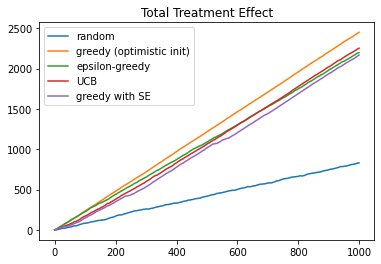

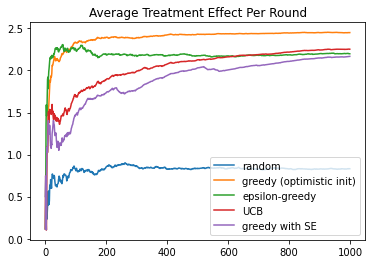

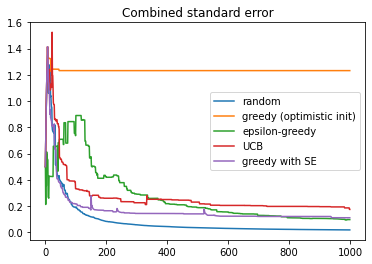

In [53]:
# Greedy with standard error
avg_te = [0]*k 
counter = [0]*k
te_greedy_with_se = []
sumte_greedy_with_se = []
avgte_greedy_with_se = []

# For recording standard errors
se_greedy_with_se = [3] * k # initialize large value
combined_se_greedy_with_se = [] 
record_greedy_with_se = {i:[] for i in range(k)}
b = 12  # We can change this

np.random.seed(12345)
for t in range(N):
    # Calculate ucb values
    adjusted_values = adjust_value(avg_te, se_greedy_with_se, b)

    # Choose best treatment from ucb values
    treatment_idx = np.argmax(adjusted_values)
    treatment_effect = treat(treatment_idx)
    te_greedy_with_se.append(treatment_effect)
    # record sum and average treatment effect up to this round
    sumte_greedy_with_se.append(np.sum(te_greedy_with_se))
    avgte_greedy_with_se.append(np.mean(te_greedy_with_se))
    # update
    avg_te, se_greedy_with_se, record_greedy_with_se, counter = update(avg_te, se_greedy_with_se, 
                                                                       record_greedy_with_se, counter, 
                                                                       treatment_idx, treatment_effect)
    # record combined_se
    combined_se_greedy_with_se.append(combine_se(se_greedy_with_se, record_greedy_with_se))

print('Number of subjects in each treatment group:', counter)
print('Final combined_se of greedy with standard error approach:', combined_se_greedy_with_se[-1])

# plot
plt.plot(sumte_random)
plt.plot(sumte_greedy_optint)
plt.plot(sumte_eps_greedy)
plt.plot(sumte_ucb)
plt.plot(sumte_greedy_with_se)
plt.title("Total Treatment Effect")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy", 'UCB', 'greedy with SE'])
plt.show()

plt.plot(avgte_random)
plt.plot(avgte_greedy_optint)
plt.plot(avgte_eps_greedy)
plt.plot(avgte_ucb)
plt.plot(avgte_greedy_with_se)
plt.title("Average Treatment Effect Per Round")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy", 'UCB', 'greedy with SE'])
plt.show()

plt.plot(combined_se_random)
plt.plot(combined_se_greedy_opt)
plt.plot(combined_se_eps_greedy)
plt.plot(combined_se_ucb)
plt.plot(combined_se_greedy_with_se)
plt.title("Combined standard error")
plt.legend(["random", "greedy (optimistic init)", "epsilon-greedy", 'UCB', 'greedy with SE'])
plt.show()

Here we notice that the trends of the greedy with standard error term are similar to the UCB method. The total and average of treatment effect over time are close to the ucb and epsilon-greedy approaches after 1000 subjects. More importantly, the combined standard error of this method here decreased faster than the UCB method (depending on the coefficient term b and c). This appraoch is useful when we have a limited number of subjects, so we can use this method to get to the statistical significance goal by using fewer subjects.

### Summary

As you can see from all the plots above, each method has it's own trade-off which can be used to fit different tasks. For this specific problem, directly incorporate standard error in the value estimation calculation directly as in appraoch 5, greedy with standard error, will make sure that we will reduce the uncertainty in our estimates of the treatment effects over time.